In [170]:
#Import Beautiful Soup, lxml, requests to scrap data from Toronto Neighborhood in Wikipedia
!pip install wikipedia
from bs4 import BeautifulSoup
import wikipedia as wp
import numpy as np 

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print("Libraries Imported!")

Libraries Imported!


# Get Table from Wikipedia 

In [171]:
html = wp.page("List of postal codes of Canada: M").html().encode("UTF-8")
df = pd.read_html(html)[0]
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [172]:
#delete Borough which is not assigned
df = df[df['Borough']!= 'Not assigned']
df.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [173]:
df['Borough'].unique()

array(['North York', 'Downtown Toronto', 'Etobicoke', 'Scarborough',
       'East York', 'York', 'East Toronto', 'West Toronto',
       'Central Toronto', 'Mississauga'], dtype=object)

In [174]:
df['Neighborhood'].unique()

array(['Parkwoods', 'Victoria Village', 'Regent Park, Harbourfront',
       'Lawrence Manor, Lawrence Heights',
       "Queen's Park, Ontario Provincial Government",
       'Islington Avenue, Humber Valley Village', 'Malvern, Rouge',
       'Don Mills', 'Parkview Hill, Woodbine Gardens',
       'Garden District, Ryerson', 'Glencairn',
       'West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale',
       'Rouge Hill, Port Union, Highland Creek', 'Woodbine Heights',
       'St. James Town', 'Humewood-Cedarvale',
       'Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood',
       'Guildwood, Morningside, West Hill', 'The Beaches', 'Berczy Park',
       'Caledonia-Fairbanks', 'Woburn', 'Leaside', 'Central Bay Street',
       'Christie', 'Cedarbrae', 'Hillcrest Village',
       'Bathurst Manor, Wilson Heights, Downsview North',
       'Thorncliffe Park', 'Richmond, Adelaide, King',
       'Dufferin, Dovercourt Village', 'Scarborough Village',
       'Fairview, H

In [175]:
#combine neighbourhoods where postcode & Borough are the same
df = df.groupby(['Postal Code','Borough'])['Neighborhood'].apply(lambda x:', '.join(x)).to_frame().reset_index()

In [176]:
df.head()

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [177]:
for index, row in df.iterrows():
    if row['Neighborhood'] == 'Not assigned':
        row['Neighborhood'] == df['Borough']
    

In [178]:
colnames = ['Postcode','Borough','Neighborhood']
df.columns = colnames

In [179]:
df.head()

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


# Add geographical coordinates to the neighborhoods

In [180]:
import pandas as pd
import io
import requests

url="https://cocl.us/Geospatial_data"
s=requests.get(url).content #bytes
lat_lng=pd.read_csv(io.StringIO(s.decode('utf-8'))) #s.decode: change bytes to string to _io.StringIO
lat_lng.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [181]:
#merge lat_lng to df
lat_lng = lat_lng.rename(columns={'Postal Code':'Postcode'})
toronto_df = pd.merge(df, lat_lng, on='Postcode')
toronto_df.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [182]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
       len(toronto_df['Borough'].unique()),
       toronto_df.shape[0]))  # shape check the dimension of df(n,m)

The dataframe has 10 boroughs and 103 neighborhoods.


# Scrap the distribution of population from wilipedia

In [183]:
html = wp.page('Demographics of Toronto').html().encode('UTF-8')

In [184]:
demo_df = pd.read_html(html)
demo_df = pd.DataFrame(demo_df)[0]

In [185]:
#TORONTO & EAST YORK
TE  = demo_df[12]
TE

,Riding,Population,Ethnic Origin #1,%,Ethnic Origin #2,%.1,Ethnic Origin #3,%.2,Ethnic Origin #4,%.3,Ethnic Origin #5,%.4,Ethnic Origin #6,%.5,Ethnic Origin #7,%.6,Ethnic Origin #8,%.7,Ethnic Origin #9,%.8
0,Spadina-Fort York,114315,English,16.4,Chinese,16.0,Irish,14.6,Canadian,14.0,Scottish,13.2,French,7.70,German,7.6,NaN,NaN,NaN,NaN
1,Beaches-East York,108435,English,24.2,Irish,19.9,Canadian,19.7,Scottish,18.9,French,8.7,German,8.40,NaN,NaN,NaN,NaN,NaN,NaN
2,Davenport,107395,Portuguese,22.7,English,13.6,Canadian,12.8,Irish,11.5,Italian,11.1,Scottish,11.00,NaN,NaN,NaN,NaN,NaN,NaN
3,Parkdale-High Park,106445,English,22.3,Irish,20.0,Scottish,18.7,Canadian,16.1,German,9.8,French,8.88,Polish,8.5,NaN,NaN,NaN,NaN
4,Toronto-Danforth,105395,English,22.9,Irish,19.5,Scottish,18.7,Canadian,18.4,Chinese,13.8,French,8.86,German,8.8,Greek,7.3,NaN,NaN
5,Toronto-St. Paul's,104940,English,18.5,Canadian,16.1,Irish,15.2,Scottish,14.8,Polish,10.3,German,7.90,Russian,7.7,Italian,7.3,French,7.2
6,University-Rosedale,100520,English,20.6,Irish,16.6,Scottish,16.3,Canadian,15.2,Chinese,14.7,German,8.70,French,7.7,Italian,7.4,NaN,NaN
7,Toronto Centre,99590,English,15.7,Canadian,13.7,Irish,13.4,Scottish,12.6,Chinese,12.5,French,7.20,NaN,NaN,NaN,NaN,NaN,NaN


In [186]:
#NORTH YORK
NY = demo_df[13]

In [187]:
#SCARBOROUGH
S = demo_df[14]

In [188]:
#ETOBICOKE & YORK
EY = demo_df[15]

In [189]:
toronto_df['Borough'].unique()

array(['Scarborough', 'North York', 'East York', 'East Toronto',
       'Central Toronto', 'Downtown Toronto', 'York', 'West Toronto',
       'Mississauga', 'Etobicoke'], dtype=object)

# Get location data using Foursquare

In [190]:
#Get geographical coordinate of Toronto
address = 'Toronto'

geolocator = Nominatim(user_agent = 'ny_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [191]:
#Connect Foursquare
CLIENT_ID = 'JIWNG1XSMPPPJ0HOWZQRGS2JPXEK4SLLHWJKQSEVROTFQRTE' # your Foursquare ID
CLIENT_SECRET = 'F143M2VMJGAH2GAD1WAVSR22CEMUYQATH5UET0PJSCHQWABZ' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
radius = 500
#print(search_query + ' .... OK!')

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
url

Your credentails:
CLIENT_ID: JIWNG1XSMPPPJ0HOWZQRGS2JPXEK4SLLHWJKQSEVROTFQRTE
CLIENT_SECRET:F143M2VMJGAH2GAD1WAVSR22CEMUYQATH5UET0PJSCHQWABZ


'https://api.foursquare.com/v2/venues/search?client_id=JIWNG1XSMPPPJ0HOWZQRGS2JPXEK4SLLHWJKQSEVROTFQRTE&client_secret=F143M2VMJGAH2GAD1WAVSR22CEMUYQATH5UET0PJSCHQWABZ&ll=43.6534817,-79.3839347&v=20180604&radius=500&limit=100'

In [192]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [193]:
#Send the GET request and examine the results
results = requests.get(url).json()
results

# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.postalCode,location.state,name,referralId
0,"[{'id': '4bf58dd8d48988d129941735', 'name': 'C...",False,4c093ee0340720a153728493,NaN,CA,NaN,Canada,NaN,184,[Canada],"[{'label': 'display', 'lat': 43.65182710471462...",43.651827,-79.383949,NaN,NaN,City Hall Council Chambers,v-1591253247
1,"[{'id': '4bf58dd8d48988d129941735', 'name': 'C...",False,4ad4c05ef964a5208ff620e3,100 Queen St. W.,CA,Toronto,Canada,at Bay St.,38,"[100 Queen St. W. (at Bay St.), Toronto ON M5H...","[{'label': 'display', 'lat': 43.65313989695342...",43.653140,-79.383967,M5H 2N2,ON,Toronto City Hall,v-1591253247
2,"[{'id': '4bf58dd8d48988d129941735', 'name': 'C...",False,5b193c42598e64002ca79b96,100 Queen St W,CA,Toronto,Canada,NaN,3,"[100 Queen St W, Toronto ON M5H 2N2, Canada]","[{'label': 'display', 'lat': 43.653454, 'lng':...",43.653454,-79.383952,M5H 2N2,ON,City of Toronto Civic Innovation Office,v-1591253247
3,"[{'id': '4bf58dd8d48988d15a941735', 'name': 'G...",False,4c0121fd9a950f47fa9208c6,100 Queen Street West,CA,Toronto,Canada,NaN,6,"[100 Queen Street West, Toronto ON, Canada]","[{'label': 'display', 'lat': 43.65350358617817...",43.653504,-79.383866,NaN,ON,City Hall Podium Green Roof,v-1591253247
4,"[{'id': '4bf58dd8d48988d162941735', 'name': 'O...",False,4fa43f81e4b098f42a5681a1,Nathan Phillips Square,CA,Toronto,Canada,NaN,95,"[Nathan Phillips Square, Toronto ON, Canada]","[{'label': 'display', 'lat': 43.652622, 'lng':...",43.652622,-79.383923,NaN,ON,the Archer / Three-Way Piece No. 2,v-1591253247


In [194]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head()

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,City Hall Council Chambers,City Hall,NaN,CA,NaN,Canada,NaN,184,[Canada],"[{'label': 'display', 'lat': 43.65182710471462...",43.651827,-79.383949,NaN,NaN,4c093ee0340720a153728493
1,Toronto City Hall,City Hall,100 Queen St. W.,CA,Toronto,Canada,at Bay St.,38,"[100 Queen St. W. (at Bay St.), Toronto ON M5H...","[{'label': 'display', 'lat': 43.65313989695342...",43.653140,-79.383967,M5H 2N2,ON,4ad4c05ef964a5208ff620e3
2,City of Toronto Civic Innovation Office,City Hall,100 Queen St W,CA,Toronto,Canada,NaN,3,"[100 Queen St W, Toronto ON M5H 2N2, Canada]","[{'label': 'display', 'lat': 43.653454, 'lng':...",43.653454,-79.383952,M5H 2N2,ON,5b193c42598e64002ca79b96
3,City Hall Podium Green Roof,Garden,100 Queen Street West,CA,Toronto,Canada,NaN,6,"[100 Queen Street West, Toronto ON, Canada]","[{'label': 'display', 'lat': 43.65350358617817...",43.653504,-79.383866,NaN,ON,4c0121fd9a950f47fa9208c6
4,the Archer / Three-Way Piece No. 2,Other Great Outdoors,Nathan Phillips Square,CA,Toronto,Canada,NaN,95,"[Nathan Phillips Square, Toronto ON, Canada]","[{'label': 'display', 'lat': 43.652622, 'lng':...",43.652622,-79.383923,NaN,ON,4fa43f81e4b098f42a5681a1


In [195]:
#Create function to know how many venues there are in Toronto

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [196]:
toronto_df.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [197]:
#List of Neighborhood that have venues in Toronto
toronto_venues = getNearbyVenues(names=toronto_df['Neighborhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [198]:
print('{} venues were returned by Foursquare.'.format(toronto_venues.shape[0]))
toronto_venues.head()

2120 venues were returned by Foursquare.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Malvern, Rouge",43.806686,-79.194353,Interprovincial Group,43.805630,-79.200378,Print Shop
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Chris Effects Painting,43.784343,-79.163742,Construction & Landscaping
3,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank


# Folium Library and Leaflet Map

In [199]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], 
                                           toronto_df['Borough'], toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

# Relationship between neighborhood and Chinese Restaurant

In [200]:
toronto_df.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [201]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Malvern, Rouge",43.806686,-79.194353,Interprovincial Group,43.805630,-79.200378,Print Shop
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Chris Effects Painting,43.784343,-79.163742,Construction & Landscaping
3,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank


In [202]:
#Number of venues per neighborhood
toronto_venues.groupby('Neighborhood').count()
x = toronto_venues.groupby('Neighborhood').count()
x.index.name = 'Neighborhood'
x.reset_index(inplace = True)
x.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,4,4,4,4,4,4
1,"Alderwood, Long Branch",6,6,6,6,6,6
2,"Bathurst Manor, Wilson Heights, Downsview North",19,19,19,19,19,19
3,Bayview Village,4,4,4,4,4,4
4,"Bedford Park, Lawrence Manor East",23,23,23,23,23,23


In [203]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
manhattan_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [204]:
# add neighborhood column back to dataframe
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0

In [205]:
toronto_chinese = toronto_grouped[['Neighborhood','Chinese Restaurant']]
toronto_chinese.head()

,Neighborhood,Chinese Restaurant
0,Agincourt,0.00
1,"Alderwood, Long Branch",0.00
2,"Bathurst Manor, Wilson Heights, Downsview North",0.00
3,Bayview Village,0.25
4,"Bedford Park, Lawrence Manor East",0.00


In [206]:
toronto_merged = pd.merge(toronto_df, toronto_chinese, on='Neighborhood')

In [207]:
toronto_merged

,Postcode,Borough,Neighborhood,Latitude,Longitude,Chinese Restaurant
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,0.000000
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,0.000000
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0.000000
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.000000
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.000000
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,0.000000
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029,0.000000
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577,0.000000
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476,0.000000
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,0.000000


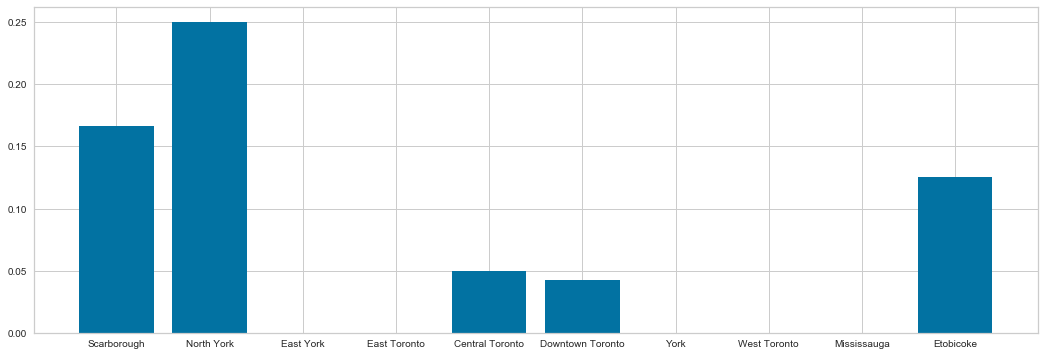

In [209]:
plt.figure(figsize = (18,6))
ax2 = plt.bar(x = 'Borough', height = 'Chinese Restaurant', data = toronto_merged)
plt.show()

In [210]:
#With the help of this bar plots we can identify the boroughs with densely populated Chinese restaurants. 
#It is drawn using seaborn library to show the distribution of Chinese restaurants in different boroughs.
##Let’s also visualize the neighborhood with Chinese Restaurants:

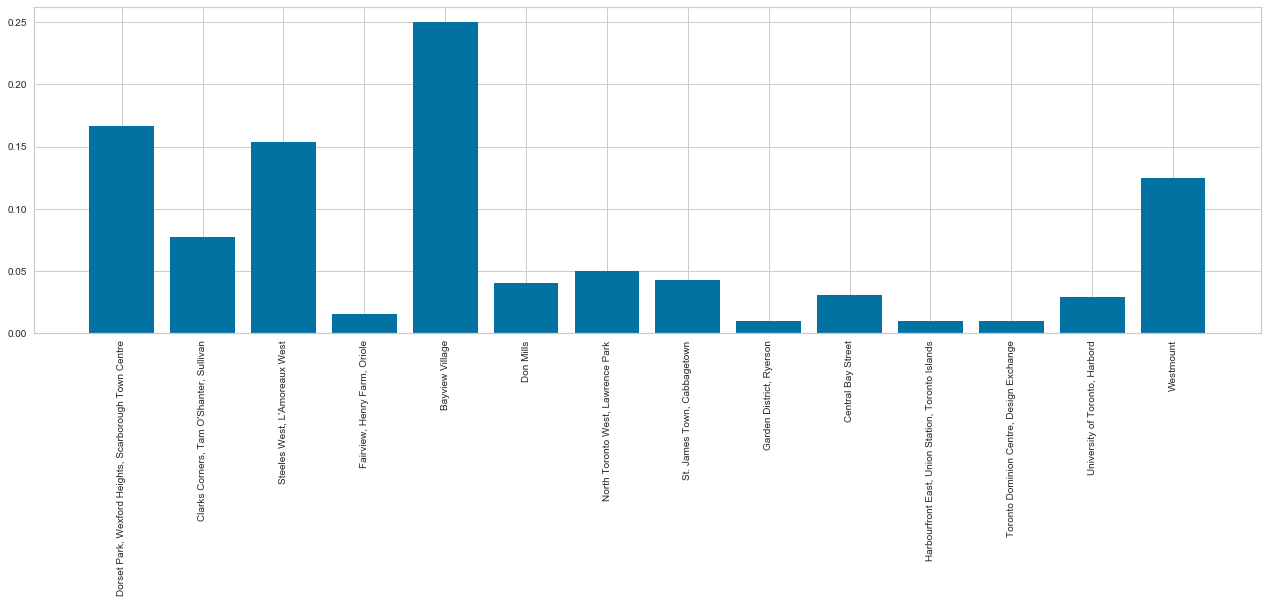

In [211]:
neighbor_form = toronto_merged[toronto_merged['Chinese Restaurant']>0]
plt.figure(figsize = (22,6))
ax2 = plt.bar(x = 'Neighborhood', height = 'Chinese Restaurant', data = neighbor_form)
plt.xticks(rotation=90)
plt.show()

# Relationship between Neighborhood and Chinese Population

In [212]:
df = TE.append([NY,S,EY], ignore_index=True)

//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [213]:
df

,%,%.1,%.2,%.3,%.4,%.5,%.6,%.7,%.8,Ethnic Origin #1,Ethnic Origin #2,Ethnic Origin #3,Ethnic Origin #4,Ethnic Origin #5,Ethnic Origin #6,Ethnic Origin #7,Ethnic Origin #8,Ethnic Origin #9,Population,Riding
0,16.4,16.0,14.6,14.0,13.2,7.70,7.6,NaN,NaN,English,Chinese,Irish,Canadian,Scottish,French,German,NaN,NaN,114315,Spadina-Fort York
1,24.2,19.9,19.7,18.9,8.7,8.40,NaN,NaN,NaN,English,Irish,Canadian,Scottish,French,German,NaN,NaN,NaN,108435,Beaches-East York
2,22.7,13.6,12.8,11.5,11.1,11.00,NaN,NaN,NaN,Portuguese,English,Canadian,Irish,Italian,Scottish,NaN,NaN,NaN,107395,Davenport
3,22.3,20.0,18.7,16.1,9.8,8.88,8.5,NaN,NaN,English,Irish,Scottish,Canadian,German,French,Polish,NaN,NaN,106445,Parkdale-High Park
4,22.9,19.5,18.7,18.4,13.8,8.86,8.8,7.3,NaN,English,Irish,Scottish,Canadian,Chinese,French,German,Greek,NaN,105395,Toronto-Danforth
5,18.5,16.1,15.2,14.8,10.3,7.90,7.7,7.3,7.2,English,Canadian,Irish,Scottish,Polish,German,Russian,Italian,French,104940,Toronto-St. Paul's
6,20.6,16.6,16.3,15.2,14.7,8.70,7.7,7.4,NaN,English,Irish,Scottish,Canadian,Chinese,German,French,Italian,NaN,100520,University-Rosedale
7,15.7,13.7,13.4,12.6,12.5,7.20,NaN,NaN,NaN,English,Canadian,Irish,Scottish,Chinese,French,NaN,NaN,NaN,99590,Toronto Centre
8,25.9,12.1,10.6,NaN,NaN,NaN,NaN,NaN,NaN,Chinese,Iranian,Korean,NaN,NaN,NaN,NaN,NaN,NaN,117405,Willowdale
9,14.7,12.6,12.0,11.0,9.7,9.50,9.2,8.4,NaN,Canadian,English,Polish,Filipino,Scottish,Italian,Irish,Russian,NaN,112925,Eglinton-Lawrence


In [214]:
df_now = df.iloc[[0,4,6,7,8,10,13,14,15,16,17,19,20],:]
df_now

,%,%.1,%.2,%.3,%.4,%.5,%.6,%.7,%.8,Ethnic Origin #1,Ethnic Origin #2,Ethnic Origin #3,Ethnic Origin #4,Ethnic Origin #5,Ethnic Origin #6,Ethnic Origin #7,Ethnic Origin #8,Ethnic Origin #9,Population,Riding
0,16.4,16.0,14.6,14.0,13.2,7.70,7.6,NaN,NaN,English,Chinese,Irish,Canadian,Scottish,French,German,NaN,NaN,114315,Spadina-Fort York
4,22.9,19.5,18.7,18.4,13.8,8.86,8.8,7.3,NaN,English,Irish,Scottish,Canadian,Chinese,French,German,Greek,NaN,105395,Toronto-Danforth
6,20.6,16.6,16.3,15.2,14.7,8.70,7.7,7.4,NaN,English,Irish,Scottish,Canadian,Chinese,German,French,Italian,NaN,100520,University-Rosedale
7,15.7,13.7,13.4,12.6,12.5,7.20,NaN,NaN,NaN,English,Canadian,Irish,Scottish,Chinese,French,NaN,NaN,NaN,99590,Toronto Centre
8,25.9,12.1,10.6,NaN,NaN,NaN,NaN,NaN,NaN,Chinese,Iranian,Korean,NaN,NaN,NaN,NaN,NaN,NaN,117405,Willowdale
10,32.4,7.3,7.3,NaN,NaN,NaN,NaN,NaN,NaN,Chinese,East Indian,Iranian,NaN,NaN,NaN,NaN,NaN,NaN,109060,Don Valley North
13,19.2,15.1,14.9,14.2,11.2,NaN,NaN,NaN,NaN,English,Canadian,Scottish,Irish,Chinese,NaN,NaN,NaN,NaN,101790,Don Valley West
14,10.6,10.4,10.1,8.9,8.1,8.00,7.8,NaN,NaN,East Indian,Canadian,English,Chinese,Irish,Scottish,Filipino,NaN,NaN,93170,Don Valley East
15,13.1,12.2,11.2,10.7,7.8,7.00,NaN,NaN,NaN,Filipino,East Indian,Canadian,Chinese,English,Sri Lankan,NaN,NaN,NaN,110450,Scarborough Centre
16,16.2,14.3,11.5,10.9,9.5,8.20,7.2,NaN,NaN,Canadian,English,Irish,Scottish,Filipino,East Indian,Chinese,NaN,NaN,108295,Scarborough Southwest


In [215]:
Chinese_population = {'Chinese_Population':[18290.4,14776.44,14544.51,12448.75,
                                            30407.895,35335.44,11400.48,8292.13,
                                           11818.15,7797.24,48985.75,7179.165,45486.26],'Riding': df_now['Riding']}

In [216]:
df_Chinese_population = pd.DataFrame(Chinese_population)

In [217]:
df_Chinese_population

,Chinese_Population,Riding
0,18290.400,Spadina-Fort York
4,14776.440,Toronto-Danforth
6,14544.510,University-Rosedale
7,12448.750,Toronto Centre
8,30407.895,Willowdale
10,35335.440,Don Valley North
13,11400.480,Don Valley West
14,8292.130,Don Valley East
15,11818.150,Scarborough Centre
16,7797.240,Scarborough Southwest


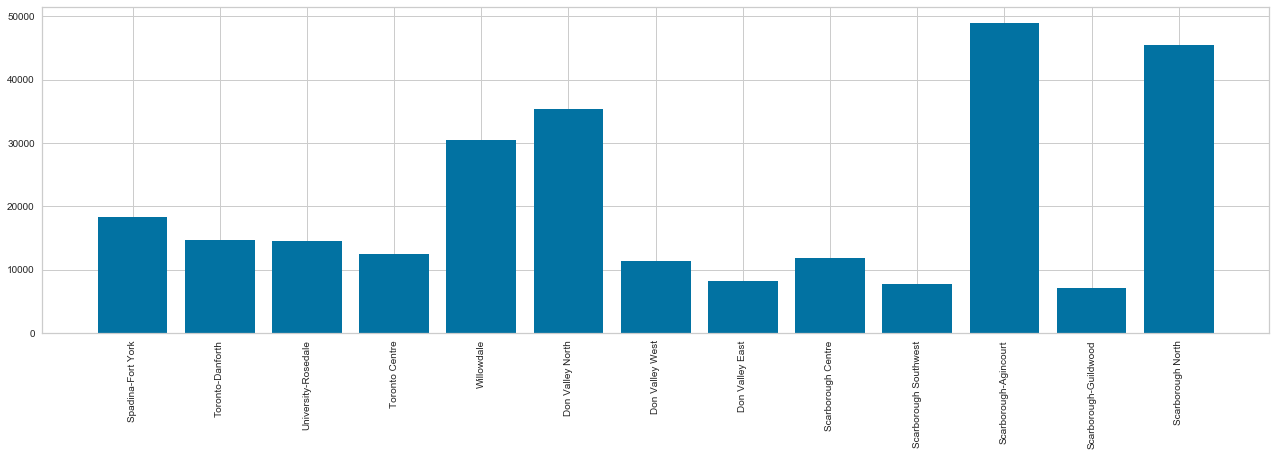

In [218]:
plt.figure(figsize = (22,6))
ax2 = plt.bar(x = 'Riding', height = 'Chinese_Population', data = df_Chinese_population)
plt.xticks(rotation=90)
plt.show()

In [219]:
#This analysis & visualization of the relationship between neighborhoods & Chinese population present in those neighborhoods helps us in identifying the highly populated Chinese neighborhoods. 
#Once we identify those neighborhoods it helps us in deciding where to place the new Chinese restaurant. 
#Chinese restaurant placed in an densely populated Chinese neighborhood is more likely to get more Chinese customers than a restaurant placed in a neighborhood with less or no Chiense population. 
#Thus this analysis helps in the determining the success of the new Chinese restaurant.

# Predictive Modeling - KMeans

In [220]:
from sklearn.cluster import KMeans

toronto_part_clustering = toronto_merged.drop(['Neighborhood', 'Postcode', 'Borough'],1)

toronto_part_clustering.head()

,Latitude,Longitude,Chinese Restaurant
0,43.806686,-79.194353,0.0
1,43.784535,-79.160497,0.0
2,43.763573,-79.188711,0.0
3,43.770992,-79.216917,0.0
4,43.773136,-79.239476,0.0


In [221]:
KM = KMeans(n_clusters = 2, max_iter=10)
KM.fit(toronto_part_clustering)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [222]:
error_cost = []
for i in range(3,11):
    KM = KMeans(n_clusters = i, max_iter = 100)
    try:
        KM.fit(toronto_part_clustering)
    except ValueError:
        print("error on line",i)
    
    error_cost.append(KM.inertia_/100)
    


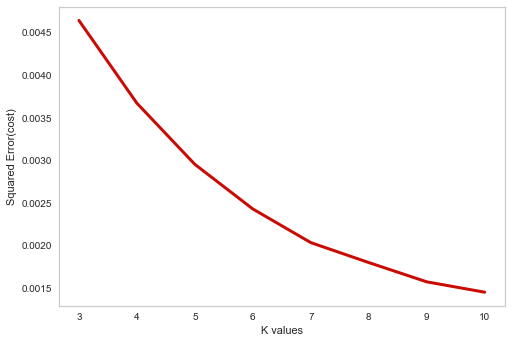

In [223]:
#plot
plt.plot(range(3,11), error_cost, color='r', linewidth='3')
plt.xlabel('K values')
plt.ylabel('Squared Error(cost)')
plt.grid(color='white', linestyle='-', linewidth=2)
plt.show()

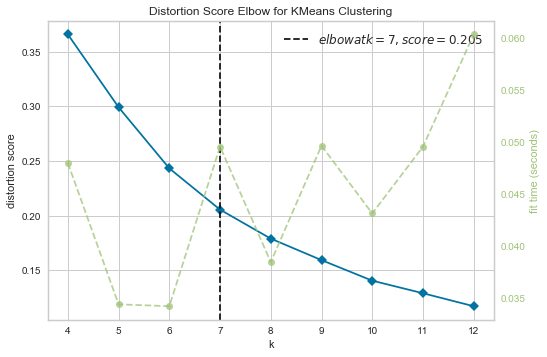

In [224]:
#Instantiate the clustering model and visualizer
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,13))

#fit data to the visualizer
visualizer.fit(toronto_part_clustering)
visualizer.show()

In [225]:
#After analysing using elbow method using distortion score & Squared error for each K value, looks like K = 7 is the best value.
#Clustering the Toronto Neighborhood Using K-Means with K =7

In [226]:
kclusters = 7

kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(toronto_part_clustering)

kmeans.labels_

array([1, 1, 1, 1, 1, 1, 5, 5, 1, 5, 4, 5, 1, 5, 1, 4, 3, 5, 4, 3, 3, 3,
       3, 5, 5, 5, 3, 2, 3, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 0, 5, 0, 3, 3,
       3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 0, 0,
       0, 0, 0, 3, 3, 3, 3, 0, 0, 0, 0, 2, 2, 6, 6, 6, 6, 0, 6, 5, 6, 6,
       6, 6, 6, 6, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [227]:
#Add group label to each row
toronto_merged.insert(0, 'Cluster Labels', kmeans.labels_)

# Exam Cluster

In [228]:
#cluster 0 
toronto_merged.loc[toronto_merged['Cluster Labels']==0]

,Cluster Labels,Postcode,Borough,Neighborhood,Latitude,Longitude,Chinese Restaurant
39,0,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0.000000
41,0,M4M,East Toronto,Studio District,43.659526,-79.340923,0.000000
46,0,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,0.000000
47,0,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049,0.000000
48,0,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,0.000000
49,0,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,0.042553
50,0,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,0.000000
51,0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.000000
52,0,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0.010000
53,0,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0.000000


In [229]:
#Cluster 1
toronto_merged.loc[toronto_merged['Cluster Labels']==1]

,Cluster Labels,Postcode,Borough,Neighborhood,Latitude,Longitude,Chinese Restaurant
0,1,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,0.0
1,1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,0.0
2,1,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0.0
3,1,M1G,Scarborough,Woburn,43.770992,-79.216917,0.0
4,1,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0
5,1,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,0.0
8,1,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476,0.0
12,1,M1S,Scarborough,Agincourt,43.794200,-79.262029,0.0
14,1,M1V,Scarborough,"Milliken, Agincourt North, Steeles East, L'Amo...",43.815252,-79.284577,0.0


In [230]:
#Cluster 2
toronto_merged.loc[toronto_merged['Cluster Labels']==2]

,Cluster Labels,Postcode,Borough,Neighborhood,Latitude,Longitude,Chinese Restaurant
27,2,M3J,North York,"Northwood Park, York University",43.767980,-79.487262,0.000
29,2,M3L,North York,Downsview,43.739015,-79.506944,0.000
30,2,M3M,North York,Downsview,43.728496,-79.495697,0.000
31,2,M3N,North York,Downsview,43.761631,-79.520999,0.000
77,2,M6L,North York,"North Park, Maple Leaf Park, Upwood Park",43.713756,-79.490074,0.000
78,2,M6M,York,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",43.691116,-79.476013,0.000
92,2,M9L,North York,Humber Summit,43.756303,-79.565963,0.000
93,2,M9M,North York,"Humberlea, Emery",43.724766,-79.532242,0.000
94,2,M9N,York,Weston,43.706876,-79.518188,0.000
95,2,M9P,Etobicoke,Westmount,43.696319,-79.532242,0.125


In [231]:
#Cluster 3
toronto_merged.loc[toronto_merged['Cluster Labels']==3]

,Cluster Labels,Postcode,Borough,Neighborhood,Latitude,Longitude,Chinese Restaurant
16,3,M2H,North York,Hillcrest Village,43.803762,-79.363452,0.00
19,3,M2M,North York,"Willowdale, Newtonbrook",43.789053,-79.408493,0.00
20,3,M2N,North York,"Willowdale, Willowdale East",43.770120,-79.408493,0.00
21,3,M2P,North York,York Mills West,43.752758,-79.400049,0.00
22,3,M2R,North York,"Willowdale, Willowdale West",43.782736,-79.442259,0.00
26,3,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,0.00
28,3,M3K,North York,Downsview,43.737473,-79.464763,0.00
42,3,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0.00
43,3,M4P,Central Toronto,Davisville North,43.712751,-79.390197,0.00
44,3,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678,0.05


In [232]:
#Cluster 4
toronto_merged.loc[toronto_merged['Cluster Labels']==4]

,Cluster Labels,Postcode,Borough,Neighborhood,Latitude,Longitude,Chinese Restaurant
10,4,M1P,Scarborough,"Dorset Park, Wexford Heights, Scarborough Town...",43.757410,-79.273304,0.166667
15,4,M1W,Scarborough,"Steeles West, L'Amoreaux West",43.799525,-79.318389,0.153846
18,4,M2K,North York,Bayview Village,43.786947,-79.385975,0.250000


In [233]:
#Cluster 5
toronto_merged.loc[toronto_merged['Cluster Labels']==5]

,Cluster Labels,Postcode,Borough,Neighborhood,Latitude,Longitude,Chinese Restaurant
6,5,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029,0.000000
7,5,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577,0.000000
9,5,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,0.000000
11,5,M1R,Scarborough,"Wexford, Maryvale",43.750072,-79.295849,0.000000
13,5,M1T,Scarborough,"Clarks Corners, Tam O'Shanter, Sullivan",43.781638,-79.304302,0.076923
17,5,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,0.014925
23,5,M3A,North York,Parkwoods,43.753259,-79.329656,0.000000
24,5,M3B,North York,Don Mills,43.745906,-79.352188,0.040000
25,5,M3C,North York,Don Mills,43.725900,-79.340923,0.040000
32,5,M4A,North York,Victoria Village,43.725882,-79.315572,0.000000


In [234]:
#Cluster 6
toronto_merged.loc[toronto_merged['Cluster Labels']==6]

,Cluster Labels,Postcode,Borough,Neighborhood,Latitude,Longitude,Chinese Restaurant
79,6,M6N,York,"Runnymede, The Junction North",43.673185,-79.487262,0.0
80,6,M6P,West Toronto,"High Park, The Junction South",43.661608,-79.464763,0.0
81,6,M6R,West Toronto,"Parkdale, Roncesvalles",43.648960,-79.456325,0.0
82,6,M6S,West Toronto,"Runnymede, Swansea",43.651571,-79.484450,0.0
84,6,M7R,Mississauga,Canada Post Gateway Processing Centre,43.636966,-79.615819,0.0
86,6,M8V,Etobicoke,"New Toronto, Mimico South, Humber Bay Shores",43.605647,-79.501321,0.0
87,6,M8W,Etobicoke,"Alderwood, Long Branch",43.602414,-79.543484,0.0
88,6,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,0.0
89,6,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,0.0
90,6,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,0.0


In [235]:
#Conclusion: Cluster 4 contains all the neighborhoods which is densely populated with Chinese restaurants. 